In [1]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos de PySpark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Función para cargar datos
from utils import load_data

In [2]:
# Iniciar una sesión de Spark
spark = SparkSession.builder \
    .appName("MalwareAnalysis") \
    .getOrCreate()

24/10/09 21:14:14 WARN Utils: Your hostname, andres-b460mds3h resolves to a loopback address: 127.0.1.1; using 192.168.1.72 instead (on interface enp3s0)
24/10/09 21:14:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/09 21:14:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/10/09 21:14:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
df = load_data()    # Cargar el conjunto de datos
rdd = df.rdd        # Convertir el DataFrame a RDD
df.printSchema()    # Imprimir la estructura del DataFrame

./data/datasetMta33featues.csv ya existe.
./data/datasetLeg33featues.csv ya existe.
root
 |-- FinFlagDist: double (nullable = true)
 |-- SynFlagDist: double (nullable = true)
 |-- RstFlagDist: double (nullable = true)
 |-- PshFlagDist: double (nullable = true)
 |-- AckFlagDist: double (nullable = true)
 |-- DNSoverIP: double (nullable = true)
 |-- TCPoverIP: double (nullable = true)
 |-- UDPoverIP: double (nullable = true)
 |-- MaxLen: double (nullable = true)
 |-- MinLen: double (nullable = true)
 |-- StdDevLen: double (nullable = true)
 |-- AvgLen: double (nullable = true)
 |-- MaxIAT: double (nullable = true)
 |-- MinIAT: double (nullable = true)
 |-- AvgIAT: double (nullable = true)
 |-- AvgWinFlow: double (nullable = true)
 |-- PktsIOratio: double (nullable = true)
 |-- 1stPktLen: double (nullable = true)
 |-- MaxLenrx: double (nullable = true)
 |-- MinLenrx: double (nullable = true)
 |-- StdDevLenrx: double (nullable = true)
 |-- AvgLenrx: double (nullable = true)
 |-- MinIATrx: 

In [4]:
# Obtener estadísticas descriptivas básicas en el RDD
max_len_stats = rdd.map(lambda row: row.MaxLen).stats() # Longitud máxima
avg_len_stats = rdd.map(lambda row: row.AvgLen).stats() # Longitud promedio
min_len_stats = rdd.map(lambda row: row.MinLen).stats() # Longitud mínima

# Mostrar estadísticas sobre la longitud de la carga útil
print("Longitud máxima de carga útil:", max_len_stats)
print("Longitud promedio de carga útil:", avg_len_stats)
print("Longitud mínima de carga útil:", min_len_stats)

Longitud máxima de carga útil: (count: 64554, mean: -8.257283745649602e-16, stdev: 0.9999999999999993, max: 6.820352829231019, min: -1.4932664409051628)
Longitud promedio de carga útil: (count: 64554, mean: -1.8388068845354155e-16, stdev: 1.0000000000000004, max: 2.7267001582368855, min: -1.3572204011707623)
Longitud mínima de carga útil: (count: 64554, mean: 3.070954161799033e-08, stdev: 0.9999999999999999, max: 3.2896288578070654, min: -4.12146753757653)


In [5]:
# Convertir cada fila del RDD en una lista de números
numeric_rdd = rdd.map(lambda row: list(row))

# Extraer los nombres de las columnas del DataFrame
column_names = df.columns

# Calcular estadísticas: Media, mínimos y máximos
stats = numeric_rdd.aggregate(
    (np.zeros(len(column_names)), np.full(len(column_names), np.inf), np.full(len(column_names), -np.inf)),
    lambda acc, row: (
        acc[0] + np.array(row),
        np.minimum(acc[1], np.array(row)),
        np.maximum(acc[2], np.array(row))
    ),
    lambda acc1, acc2: (
        acc1[0] + acc2[0],
        np.minimum(acc1[1], acc2[1]),
        np.maximum(acc1[2], acc2[2])
    )
)

# Calcular la media
count = numeric_rdd.count()
mean_values = stats[0] / count

# Mostrar resultados
results_df = pd.DataFrame({
    'Feature': column_names,
    'Media': mean_values,
    'Mínimos': stats[1],
    'Máximos': stats[2]
})

print(results_df)

                Feature         Media    Mínimos    Máximos
0           FinFlagDist -2.450764e-14  -1.204652   2.548173
1           SynFlagDist -2.054161e-14  -1.407562   2.748681
2           RstFlagDist  2.426108e-14  -0.716937   1.893017
3           PshFlagDist -1.536042e-14  -1.350512   2.665581
4           AckFlagDist -4.022380e-15  -2.047207   2.988854
5             DNSoverIP -9.583973e-15  -0.154516   6.778562
6             TCPoverIP -1.063007e-14  -7.182148   0.154711
7             UDPoverIP  1.536482e-14  -0.156991   6.836627
8                MaxLen  1.268001e-16  -1.493266   6.820353
9                MinLen  3.070957e-08  -4.121468   3.289629
10            StdDevLen  1.620223e-15 -11.942687  13.659449
11               AvgLen -2.134468e-15  -1.357220   2.726700
12               MaxIAT  1.993579e-15  -1.340114   2.825260
13               MinIAT -7.836949e-17 -76.297443   9.731742
14               AvgIAT -4.099869e-15  -1.121468   2.114340
15           AvgWinFlow -2.476124e-15  -

In [6]:
def covariance_matrix(numeric_rdd, column_names, selected_columns):
    # Obtener los índices de las columnas seleccionadas
    indices = [column_names.index(col) for col in selected_columns]

    # Extraer las columnas seleccionadas del RDD
    data = np.array(numeric_rdd.map(lambda row: [row[i] for i in indices]).collect())

    # Calcular la matriz de covarianza
    cov_matrix = np.cov(data, rowvar=False)

    cov_df = pd.DataFrame(cov_matrix, index=selected_columns, columns=selected_columns)

    return cov_df

# Definir las columnas seleccionadas para el análisis
selected_columns = ["FinFlagDist", "SynFlagDist", "RstFlagDist", "PshFlagDist", "AckFlagDist"]

# Calcular y mostrar la matriz de covarianza
covariance_df = covariance_matrix(numeric_rdd, column_names, selected_columns)
print("Matriz de Covarianza:")
print(covariance_df)

Matriz de Covarianza:
             FinFlagDist  SynFlagDist  RstFlagDist  PshFlagDist  AckFlagDist
FinFlagDist     1.000015     0.819541    -0.208698     0.635949     0.697114
SynFlagDist     0.819541     1.000015    -0.274748     0.774588     0.812645
RstFlagDist    -0.208698    -0.274748     1.000015    -0.313690    -0.286271
PshFlagDist     0.635949     0.774588    -0.313690     1.000015     0.931981
AckFlagDist     0.697114     0.812645    -0.286271     0.931981     1.000015


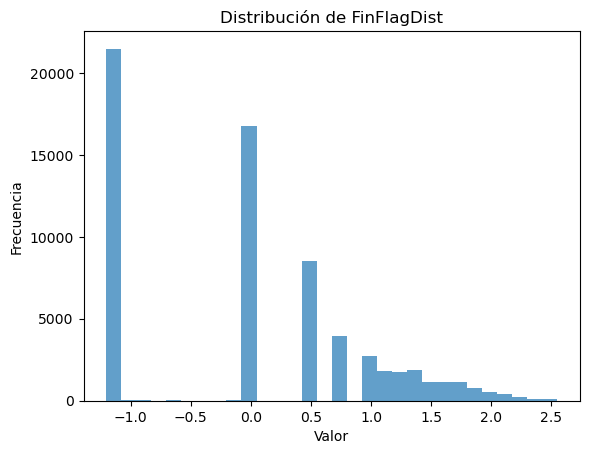

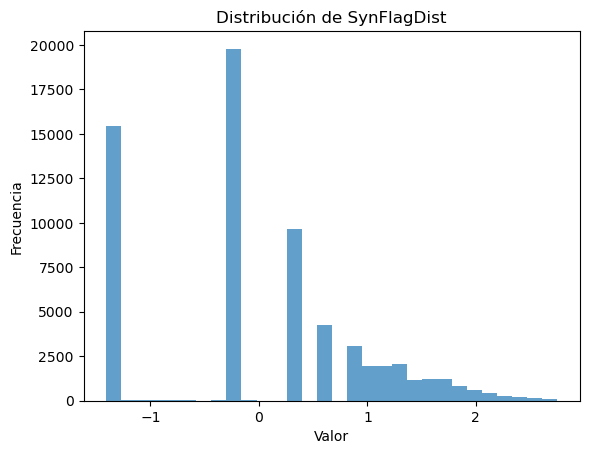

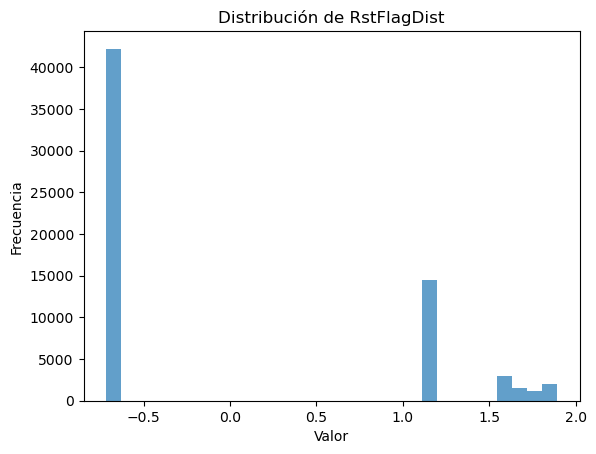

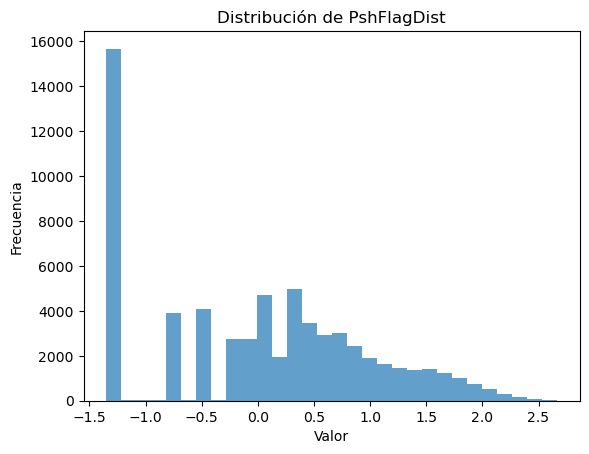

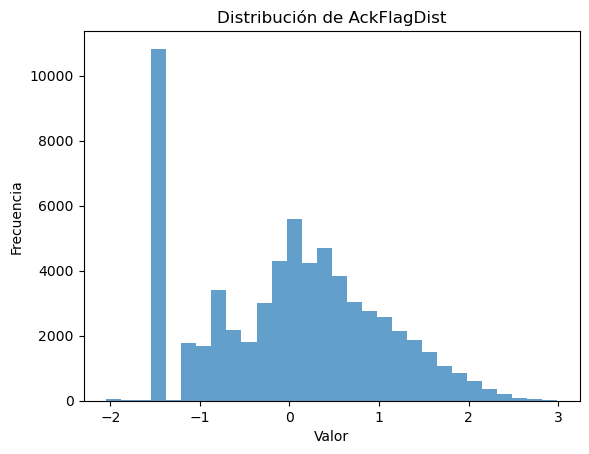

In [7]:
# Histograma para cada característica seleccionada
for feature in selected_columns:
    plt.hist(numeric_rdd.map(lambda row: row[column_names.index(feature)]).collect(), bins=30, alpha=0.7)
    plt.title(f'Distribución de {feature}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()

In [8]:
# Lista para almacenar el conteo de valores atípicos
outlier_counts = []

# Calcular IQR y detectar valores atípicos
for feature_index, feature_name in enumerate(column_names):
    feature_data = np.array(numeric_rdd.map(lambda row: row[feature_index]).collect())
    q1, q3 = np.percentile(feature_data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = len(feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)])

    # Almacenar el conteo de valores atípicos
    outlier_counts.append((feature_name, outlier_count))

# Crear un DataFrame de Pandas con los resultados
outlier_df = pd.DataFrame(outlier_counts, columns=['Característica', 'Conteo Valores Atípicos'])

# Mostrar el DataFrame
print(outlier_df)

         Característica  Conteo Valores Atípicos
0           FinFlagDist                        0
1           SynFlagDist                     1713
2           RstFlagDist                        0
3           PshFlagDist                        0
4           AckFlagDist                       28
5             DNSoverIP                     1550
6             TCPoverIP                     1669
7             UDPoverIP                     1644
8                MaxLen                      181
9                MinLen                       32
10            StdDevLen                      288
11               AvgLen                        0
12               MaxIAT                        0
13               MinIAT                    12067
14               AvgIAT                        0
15           AvgWinFlow                        0
16          PktsIOratio                     5593
17            1stPktLen                        3
18             MaxLenrx                      245
19             MinLe

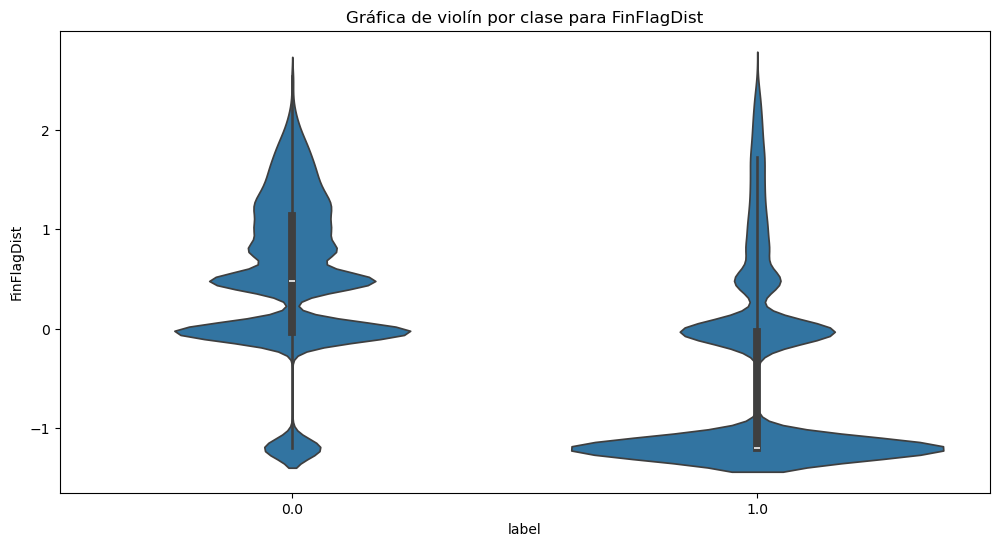

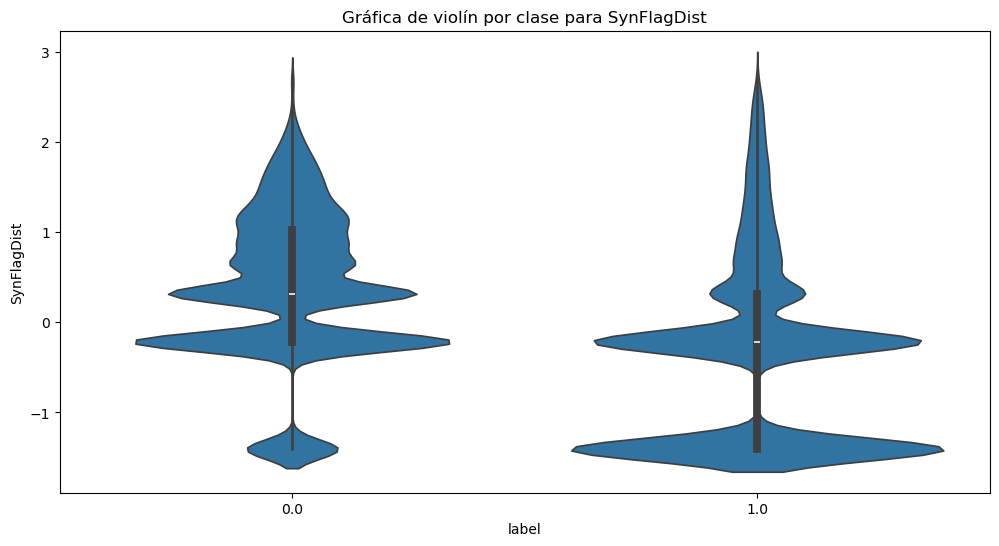

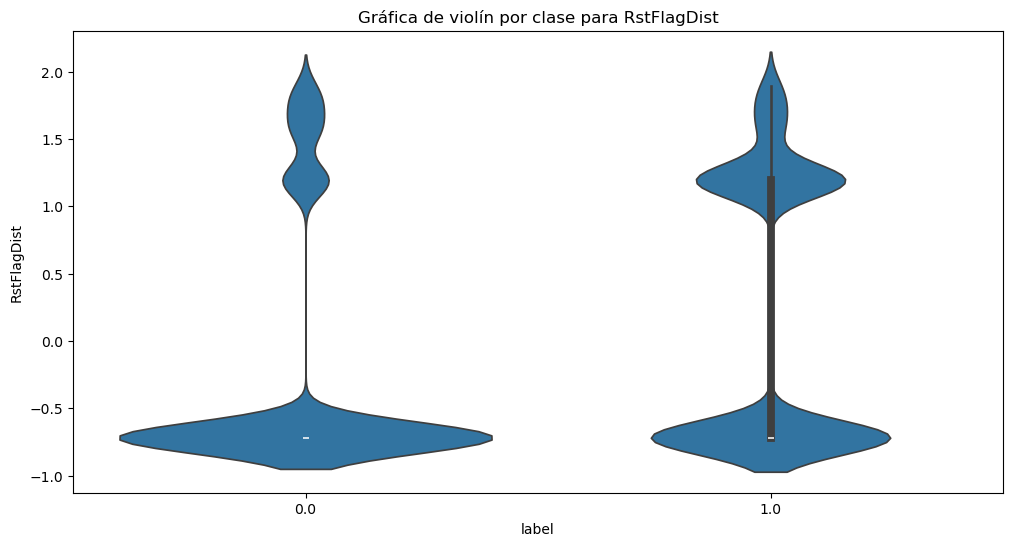

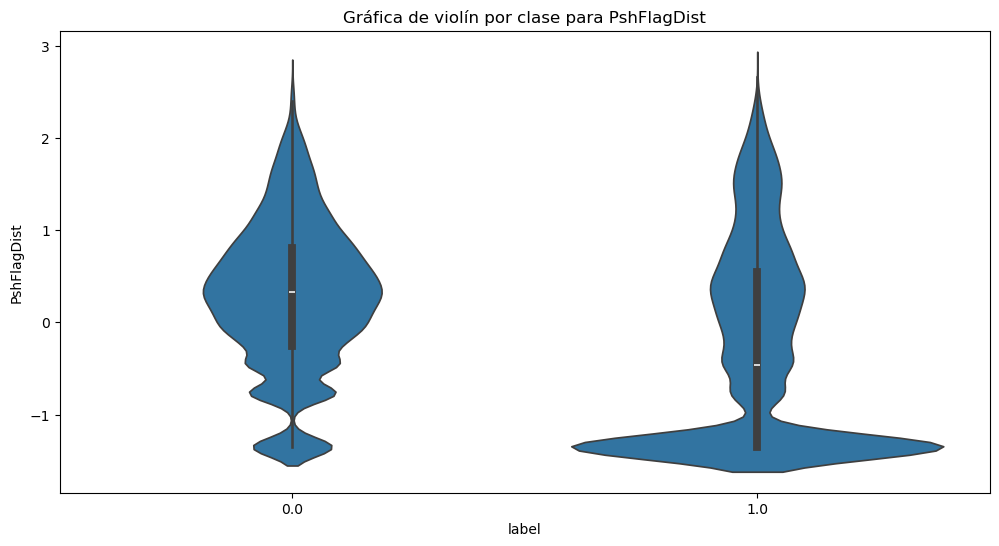

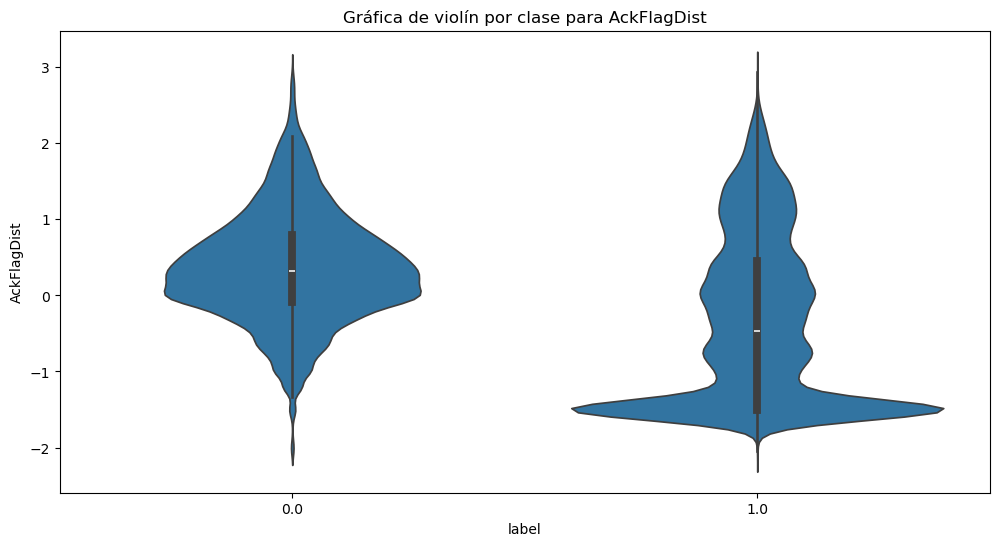

In [9]:
# Convertir el RDD a un DataFrame de Pandas para visualización
data = numeric_rdd.collect()
df = pd.DataFrame(data, columns=column_names)

# Gráficas de violín
for feature in selected_columns:
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x='label', y=feature)
    plt.title(f'Gráfica de violín por clase para {feature}')
    plt.show()

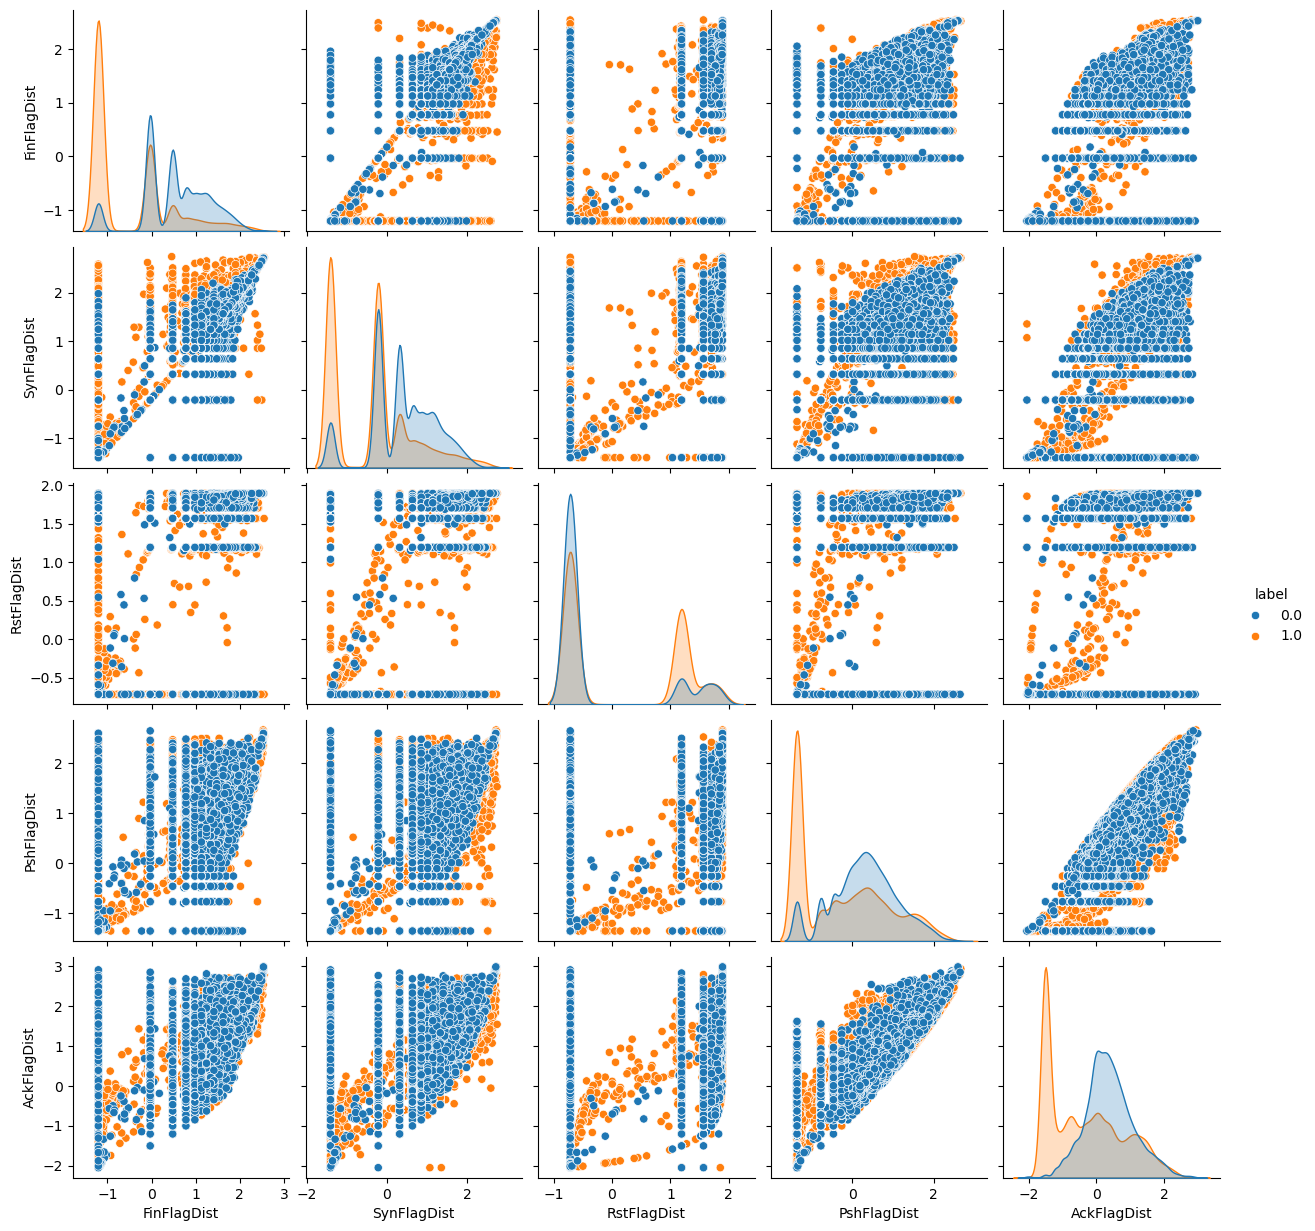

In [10]:
# Escoger sólo las columnas seleccionadas y 'label'
df_selected = df[selected_columns + ['label']]

# Crear un pairplot para visualizar la relación entre características
sns.pairplot(df_selected, hue='label')
plt.show()

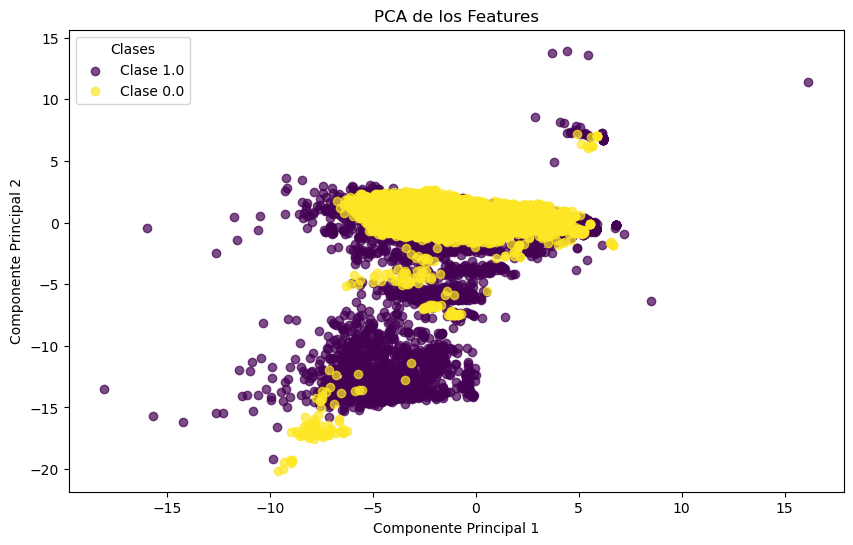

In [12]:
# Crear un DataFrame
df_for_pca = spark.createDataFrame(numeric_rdd, schema=column_names).persist()

# Excluir la columna 'label' para crear las características
feature_columns = column_names[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Crear un pipeline que incluya el VectorAssembler y el PCA
pca = PCA(k=2, inputCol='features', outputCol='pcaFeatures')
pipeline = Pipeline(stages=[assembler, pca])

# Obtener resultados del PCA
model = pipeline.fit(df_for_pca)
results = model.transform(df_for_pca).select('pcaFeatures', 'label')

# Convertir a pandas para facilitar la visualización
pandas_result = results.toPandas()
pca_result = np.vstack(pandas_result['pcaFeatures'].values)
labels = pandas_result['label'].values

# Graficar los resultados
unique_labels = np.unique(labels)[::-1]
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                color=colors[i], label=f'Clase {label}', alpha=0.7)


plt.title('PCA de los Features')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clases', loc='best')
plt.show()

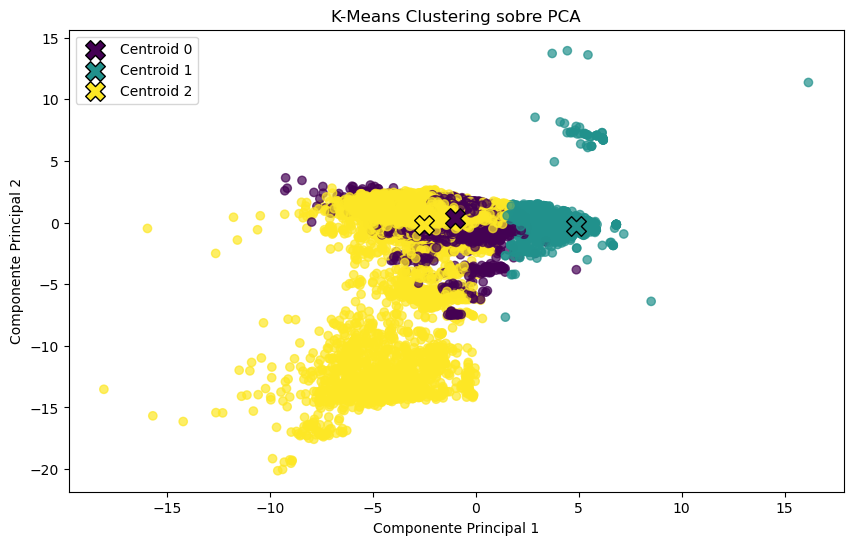

In [13]:
df_features = assembler.transform(df_for_pca)

# Aplicar K-Means
kmeans = KMeans(k=3, seed=1, featuresCol='features')
kmeans_model = kmeans.fit(df_features)

# Predicciones de K-Means
predictions = kmeans_model.transform(df_features)

# Obtener los clústeres predichos
predicted_clusters = np.array(predictions.select('prediction').collect())

# Obtener los centroides en el espacio original
centroids_original = np.array(kmeans_model.clusterCenters())

# Aplicar PCA para visualización
pca_result = np.array(pipeline.fit(df_for_pca).transform(df_for_pca).select('pcaFeatures').rdd.map(lambda x: x[0]).collect())

# Aplicar PCA a los centroides
centroids_df = spark.createDataFrame(centroids_original.tolist(), schema=feature_columns)
centroids_pca_result = model.transform(centroids_df).select('pcaFeatures')
centroids_pca = np.array(centroids_pca_result.select('pcaFeatures').rdd.map(lambda x: x[0]).collect())

# Visualización de los clústeres en el espacio reducido del PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=predicted_clusters, cmap='viridis', alpha=0.7)
colormap = scatter.cmap
norm = scatter.norm

# Dibujar los centroides
for i, centroid in enumerate(centroids_pca):
    centroid_color = colormap(norm(i))  # Color correspondiente del clúster
    plt.scatter(centroid[0], centroid[1], s=200, marker='X', label=f'Centroid {i}', color=centroid_color, edgecolor='k')

plt.title('K-Means Clustering sobre PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

In [14]:
# Dividir el DataFrame en conjuntos de entrenamiento y prueba
train_data, test_data = df_features.randomSplit([0.7, 0.3], seed=42)

# Entrenar el modelo de regresión logística
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lr_model = lr.fit(train_data)

# Hacer predicciones
predictions = lr_model.transform(test_data)

# Evaluar el modelo
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Exactitud del modelo: {accuracy:.2f}")

# Mostrar la matriz de confusión
predictions.groupBy('label', 'prediction').count().show()

# Obtener AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
roc_auc = binary_evaluator.evaluate(predictions)
print(f"AUC: {roc_auc:.2f}")

Exactitud del modelo: 0.97
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 9938|
|  1.0|       0.0|  178|
|  0.0|       1.0|  304|
|  0.0|       0.0| 8687|
+-----+----------+-----+

AUC: 0.97


In [15]:
spark.stop()